# UNHCR Forcibly Displaced Populations Casptone Project

## Logistic Regression

---


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn import preprocessing
import warnings

In [5]:
warnings.filterwarnings('ignore')

### Load the data

In [6]:
df = pd.read_csv('/Users/dayosangowawa/Desktop/GA/DSI20-lessons/projects/project-capstone/My Capstone/Forcibly displaced persons - Capstone Dayo Sangowawa/cleaned_unhcrdf_final.csv')
df.head()

,Unnamed: 0,country_of_origin,country_of_asylum,population_type,urban_or_rural_location,accommodation_type,female_aged_0-4 years,female_aged_5-11 years,female_aged_12-17 years,female_aged_18-59 years,female_aged_over_60_years,male_aged_0-4_years,male_aged_5-11_years,male_aged_12-17 years,male_aged_18-59_years,male_aged_over_60_years
0,0,Colombia,Aruba,ASY,Urban,I,0,0,0,0,0,0,0,0,5,0
1,1,Cuba,Aruba,ASY,Urban,I,0,0,0,0,0,0,0,0,0,0
2,2,Afghanistan,Afghanistan,IDP,Rural,I,0,14,16,37,0,0,15,17,38,5
3,3,Afghanistan,Afghanistan,IDP,Urban,Q,74,810,853,2004,140,75,840,921,2278,206
4,4,Afghanistan,Afghanistan,IDP,Urban,Q,12,130,138,321,21,12,135,147,365,33


In [7]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [8]:
y = df.pop('accommodation_type')
X = pd.get_dummies(df, drop_first=True)

In [9]:
print('Baseline prediction: ', y.value_counts(normalize=True).max())

Baseline prediction:  0.8497186815375424


In [10]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

In [11]:
y
#'0 'if it is 'I 'and '1' if it is 'other'. 

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [12]:
y = y.ravel()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)

In [14]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Lasso Regularization - GridSearch

In [15]:
lr_lasso = LogisticRegression(penalty = 'l1', max_iter=10)

In [16]:
params = {'C': np.linspace(1, 2, 10), 
        'solver' :['liblinear', 'saga']}

In [17]:
lr_lasso_gs = GridSearchCV(estimator=lr_lasso, param_grid=params, cv=5)

In [18]:
lr_lasso_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10, penalty='l1'),
             param_grid={'C': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                         'solver': ['liblinear', 'saga']})

In [19]:
lr_lasso_gs.best_params_

{'C': 1.1111111111111112, 'solver': 'liblinear'}

### Using the best parameters from the Grid Search - Lasso

In [22]:
lr_lasso_best = LogisticRegression(penalty = 'l1', C = 1.1111111111111112, solver='liblinear')

In [23]:
lr_lasso_best.fit(X_train, y_train)

LogisticRegression(C=1.1111111111111112, penalty='l1', solver='liblinear')

In [24]:
print('Accuracy score - train: ', lr_lasso_best.score(X_train, y_train))
print('Accuracy score - test: ', lr_lasso_best.score(X_test, y_test))
print('Mean CV score - train: ', cross_val_score(lr_lasso_best, X_train, y_train, cv=5).mean())

Accuracy score - train:  0.945369390676542
Accuracy score - test:  0.9441747572815534
Mean CV score - train:  0.9439378876879154


### Evaluation - Lasso

In [25]:
import scikitplot as skplt

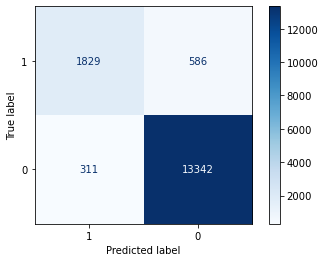

In [26]:
plot_confusion_matrix(lr_lasso_best, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [27]:
y_test_pred_lasso = lr_lasso_best.predict(X_test)

In [28]:
print(classification_report(y_test, y_test_pred_lasso))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     13653
           1       0.85      0.76      0.80      2415

    accuracy                           0.94     16068
   macro avg       0.91      0.87      0.89     16068
weighted avg       0.94      0.94      0.94     16068



In [29]:
print(f1_score(y_test, y_test_pred_lasso))

0.803073545554336


In [30]:
probabilities_train_lasso = lr_lasso_best.predict_proba(X_train)

In [31]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(lr_lasso_best.classes_)))

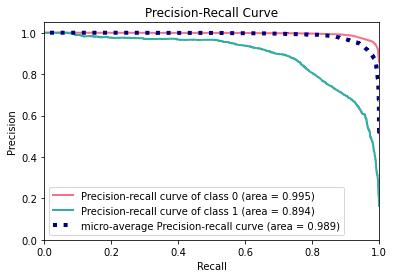

In [32]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train_lasso, cmap=cmap)
plt.show()

In [33]:
print('Average precision score: ', average_precision_score(y_train, probabilities_train_lasso[:, 1]))

Average precision score:  0.8944133750414459


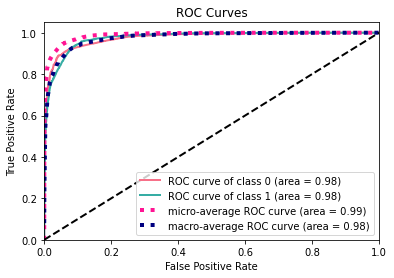

In [34]:
skplt.metrics.plot_roc(y_train, probabilities_train_lasso, cmap=cmap)
plt.show()

In [35]:
print('Area under the curve : ', roc_auc_score(y_train, probabilities_train_lasso[:, 1]))

Area under the curve :  0.9755281790883066


### Ridge Regularization - GridSearch

In [42]:
lr_ridge = LogisticRegression(penalty='l2', max_iter = 10)

In [43]:
params = {'C': np.linspace(1, 2, 10), 
        'solver' :['lbfgs', 'newton-cg', 'sag']}

In [44]:
lr_ridge_gs = GridSearchCV(estimator=lr_ridge, param_grid=params, cv=5)

In [45]:
lr_ridge_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10),
             param_grid={'C': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                         'solver': ['lbfgs', 'newton-cg', 'sag']})

In [46]:
lr_ridge_gs.best_params_

{'C': 1.1111111111111112, 'solver': 'newton-cg'}

### Using the best parameters from the Grid Search - Ridge

In [47]:
lr_ridge = LogisticRegression(penalty='l2', C = 1.1111111111111112, solver = 'newton-cg')

In [48]:
lr_ridge.fit(X_train, y_train)

LogisticRegression(C=1.1111111111111112, solver='newton-cg')

In [49]:
print('Accuracy score - train: ', lr_ridge.score(X_train, y_train))
print('Accuracy score - test: ', lr_ridge.score(X_test, y_test))
print('Mean CV score - train: ', cross_val_score(lr_ridge, X_train, y_train, cv=5).mean())

Accuracy score - train:  0.9454160702060124
Accuracy score - test:  0.9441747572815534
Mean CV score - train:  0.944000125123733


### Evaluation - Ridge

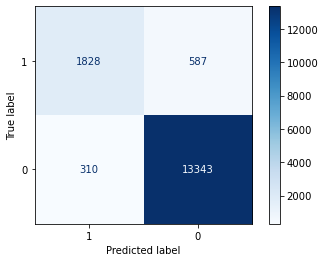

In [50]:
plot_confusion_matrix(lr_ridge, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [51]:
y_test_pred_ridge = lr_ridge.predict(X_test)

In [52]:
print(classification_report(y_test, y_test_pred_ridge))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     13653
           1       0.86      0.76      0.80      2415

    accuracy                           0.94     16068
   macro avg       0.91      0.87      0.89     16068
weighted avg       0.94      0.94      0.94     16068



In [53]:
print(f1_score(y_test, y_test_pred_ridge))

0.8029870415110916


In [54]:
probabilities_train_ridge = lr_ridge.predict_proba(X_train)

In [55]:
cmap = ListedColormap(sns.color_palette("husl", len(lr_ridge.classes_)))

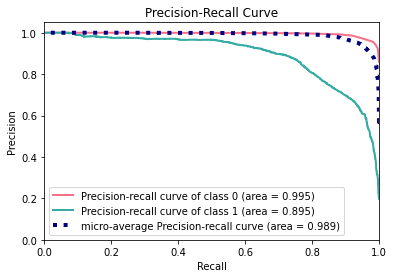

In [56]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train_ridge, cmap=cmap)
plt.show()

In [57]:
print('Average precision score: ', average_precision_score(y_train, probabilities_train_ridge[:, 1]))

Average precision score:  0.8945427927160983


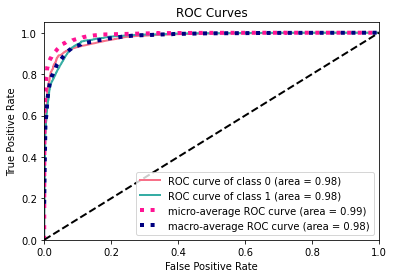

In [58]:
skplt.metrics.plot_roc(y_train, probabilities_train_ridge, cmap=cmap)
plt.show()

In [59]:
print('Area under the curve: ', roc_auc_score(y_train, probabilities_train_ridge[:, 1]))

Area under the curve:  0.9756129430591417
